# Self-Driving Car Engineer Nanodegree

## Project: **Advanced Lane Finding**


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Camera Calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

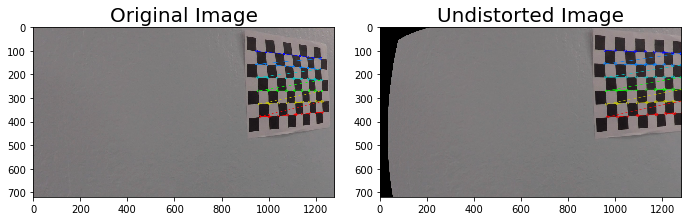

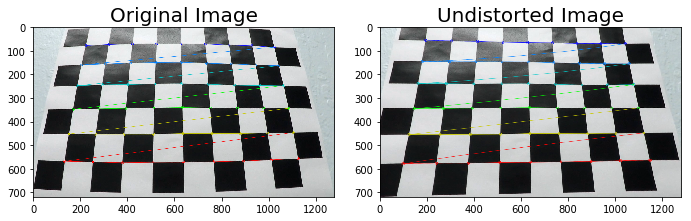

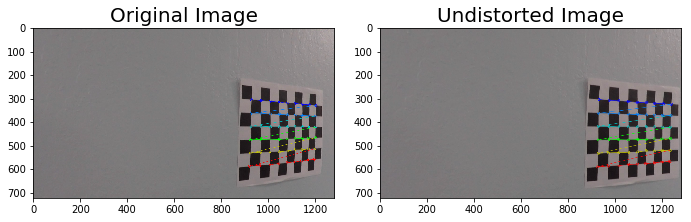

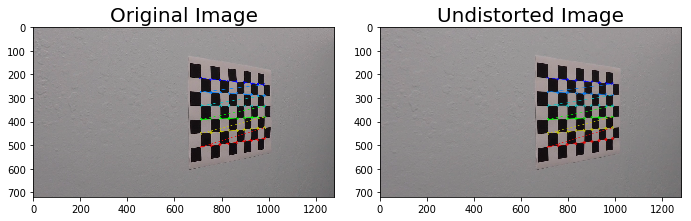

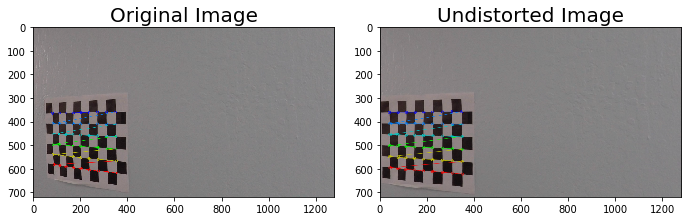

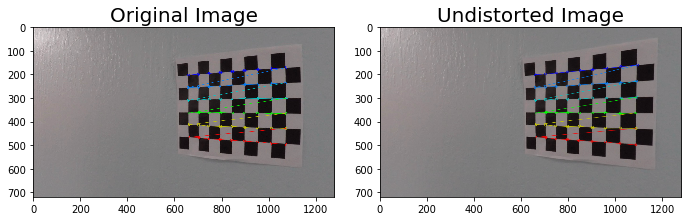

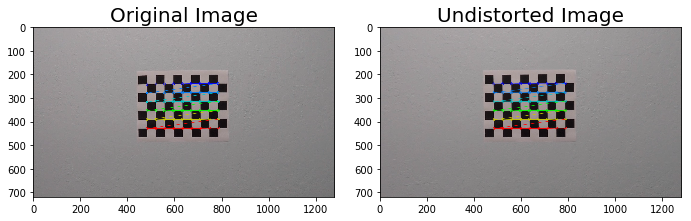

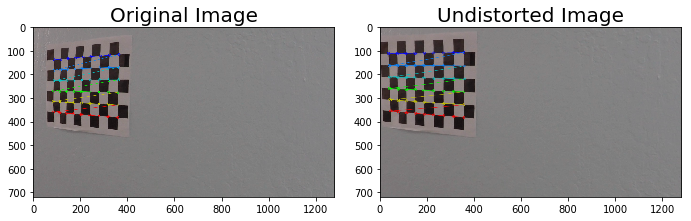

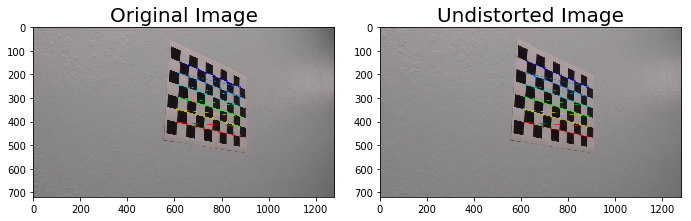

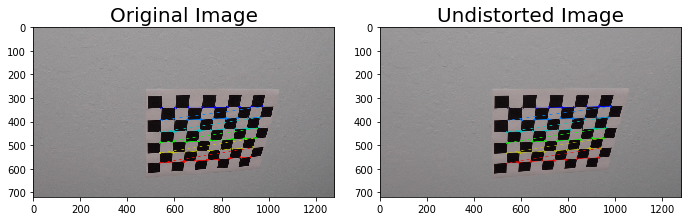

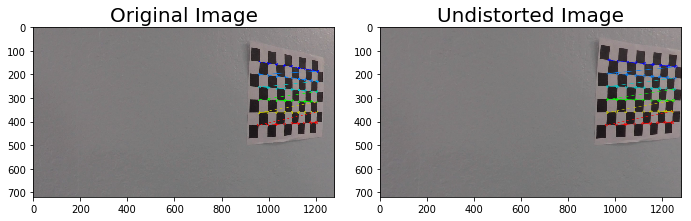

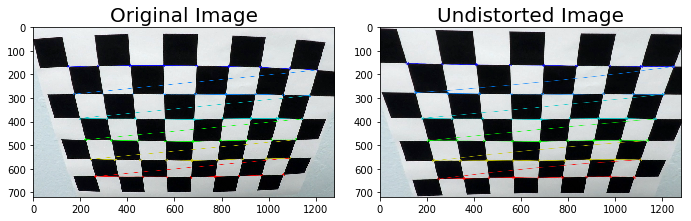

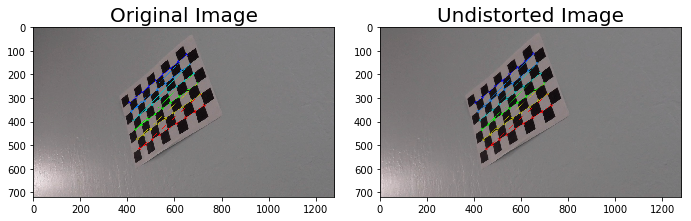

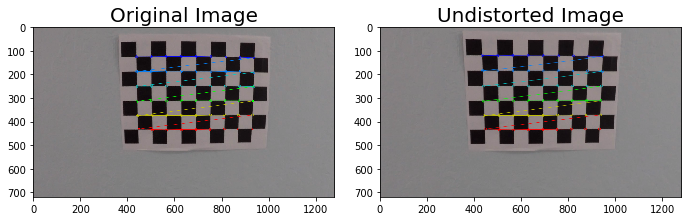

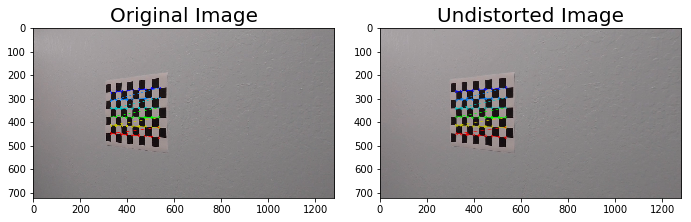

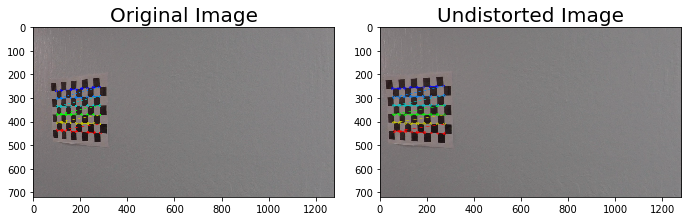

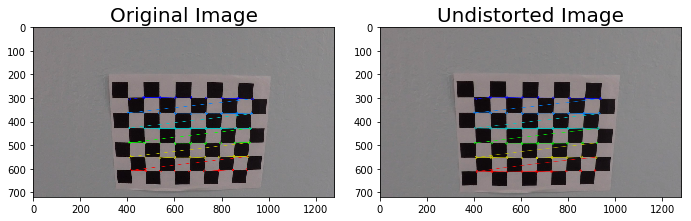

In [2]:

#Arrays to store object points and image points for all Arrays images

objpoints = [] #3D points in the real world space
imgpoints = [] #2D points in the mage plane

# prepare object points
nx = 9# Number of inside corners in x
ny = 6# Number of inside corners in y

objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

images = glob.glob('camera_cal/calibration*.jpg')

def cal_undistort(img, objpoints, imgpoints):
    # Using cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None)
    return undist

for fname in images:
    #Read each image
    img = cv2.imread(fname)
    
    
    #Convert Image to graygcale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #Find the Chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    #If corners are found append object points and image points
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #draw the corners
        img =  cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        #undistort the image
        undistorted = cal_undistort(img,objpoints,imgpoints)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    
    
    

## Apply Distortion Correction to Raw Images

In [ ]:

images = glob.glob('test_images/test*.jpg')
for fname in images:
    #Read each image
    img = cv2.imread(fname)
    undistorted = cal_undistort(img,objpoints,imgpoints)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  

## Create a thresholded binary image

In [3]:
def threshold(img):
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    
    
    #R channel from RGB
    r_channel = img[:,:,0]
    
    #B channel from LAB
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    #L channel from LUV
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    r_thresh_min = 215
    r_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1) | (r_binary == 1)] = 1
    
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(color_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


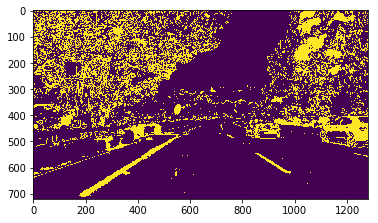

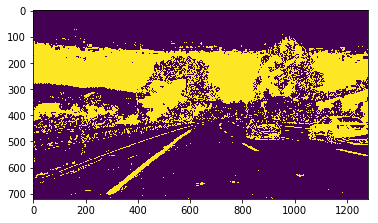

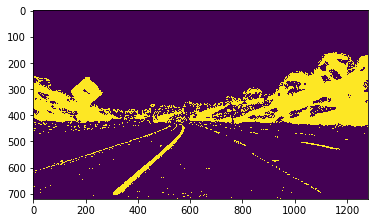

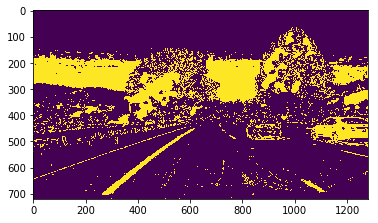

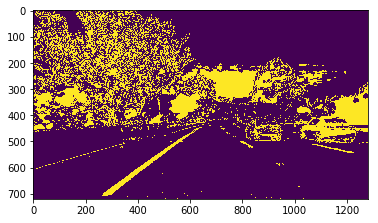

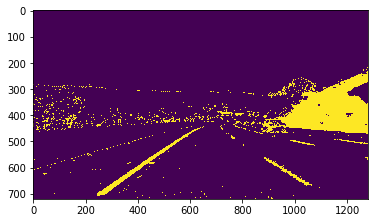

In [4]:

images = glob.glob('test_images/test*.jpg')

for fname in images:
    #read a raw image
    img =  cv2.imread(fname)
    
    #Undistort raw image
    undistort = cal_undistort(img,objpoints,imgpoints)
    
    #Apply Threshold
    combined_binary = threshold(undistort)
    
    plt.imshow(combined_binary)
    plt.figure()

## Apply Perspective transform over undistorted raw images

In [5]:
def perspective(img):
    
    #set source and destination points
    src = np.float32([(203,720),(1099,720),(707,463),(580,463)])
    dst = np.float32([(203,720),(1099,720),(1099,0),(203,0)])
    
    #apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    
    return warped




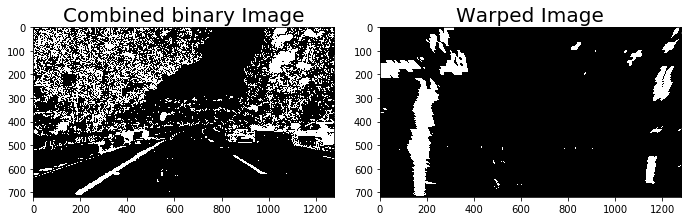

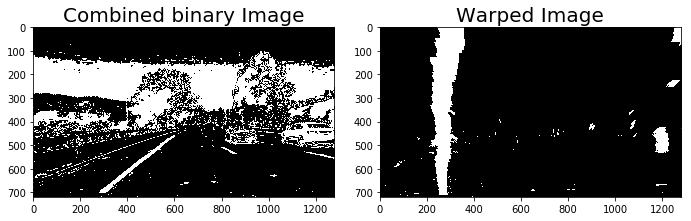

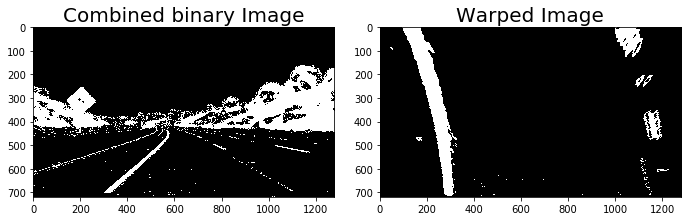

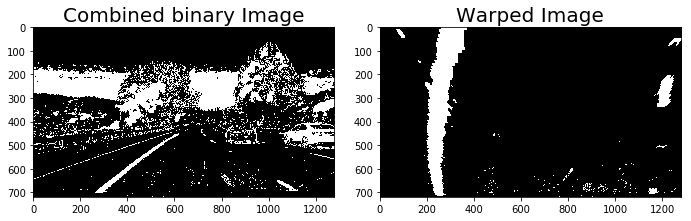

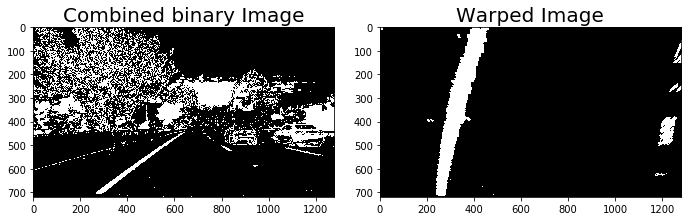

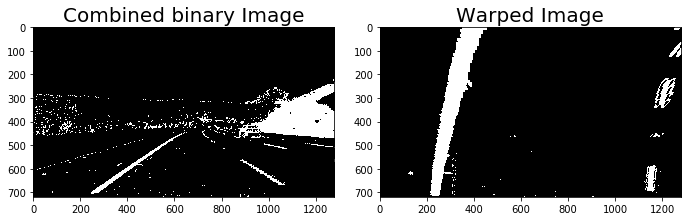

In [6]:
images = glob.glob('test_images/test*.jpg')

warped_images = []

for fname in images:
    #read a raw image
    img =  cv2.imread(fname)
    
    #Undistort raw image
    undistort = cal_undistort(img,objpoints,imgpoints)
    
    #Apply Threshold
    combined_binary = threshold(undistort)
    
    #Apply region of interest mask
    #Next we create a masked edges images with cv2.fillPoly()
    #vertices = np.array([[(combined_binary.shape[1]*0.1,combined_binary.shape[0]*0.95),(combined_binary.shape[1]*0.6,combined_binary.shape[0]*0.5), (combined_binary.shape[1]*0.6,combined_binary.shape[0]*0.6), (combined_binary.shape[1]*0.9,combined_binary.shape[0]*0.9)]], dtype=np.int32)
    
    #masked_image = region_of_interest(combined_binary,vertices)
    
    #Perform Perspective transform
    warped = perspective(combined_binary)
    
    #Save Warped Images
    warped_images.append(warped)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(combined_binary,cmap='gray')
    ax1.set_title('Combined binary Image', fontsize=20)
    ax2.imshow(warped,cmap='gray')
    ax2.set_title('Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## Detect lane pixels and fit to find the lane boundary.

In [7]:

def find_lane_pixels(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped,warped, warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit


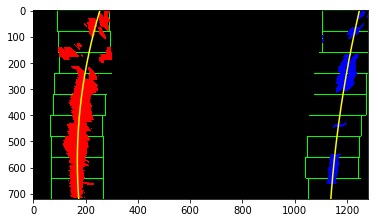

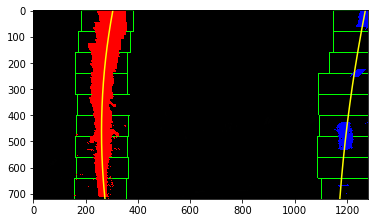

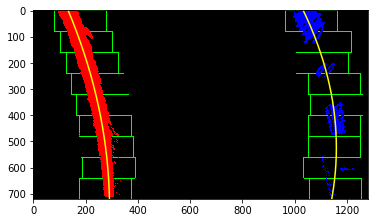

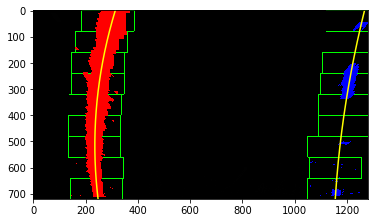

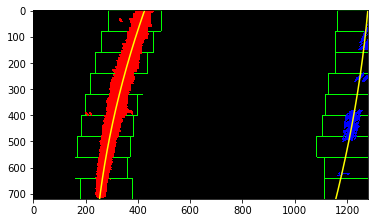

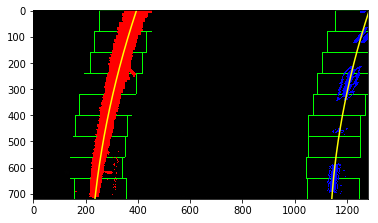

In [8]:
#Fit polynomial and show lane lines
for img in warped_images:
    lane_lines,left_fit,right_fit = fit_polynomial(img)
    plt.imshow(lane_lines)
    plt.figure()

## Determine the curvature of the lane 

In [9]:
def measure_curvature(x_val,warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/896 # meteres per pixel in x dimension
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_val = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(y_val)
    
    # Calculation of R_curve (radius of curvature)
    fit_cr = np.polyfit(y_val*ym_per_pix, x_val*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
       
    return curverad

## Find Lane Lines by searching from Prior

In [10]:

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    
    ## End visualization steps ##
    
    return result,left_fitx,right_fitx


In [11]:
def draw_radius_curvature(warped,img,left_fitx,right_fitx):
    #Measuring Radius of Curvature for left and right lanes
    left_curverad = measure_curvature(left_fitx,warped)
    right_curverad = measure_curvature(right_fitx,warped)    
    average_curverad = (left_curverad + right_curverad)/2
    
    # meters per pixel in y dimension
    x_m_per_pix = 3.7/896
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    # Car center, Assuming the camera is mounted in the middle
    car_center = img.shape[1]/2
    # Calculate center offset
    center_offset = (lane_center - car_center) * x_m_per_pix
    
    #Add Curvature and offset information to image
    cv2.putText(img,"Curvature = %0.2f m" %average_curverad , (120, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
    cv2.putText(img, "Center Offset = %0.2f m" %center_offset, (120, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
    
    return img
    

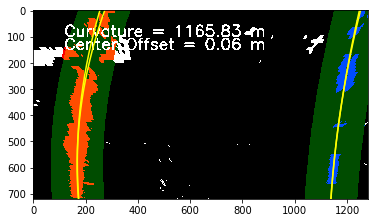

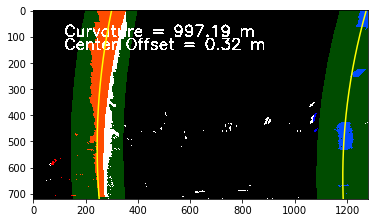

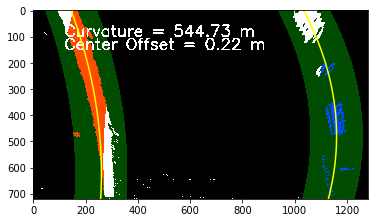

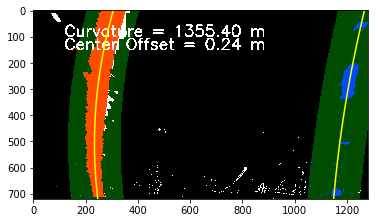

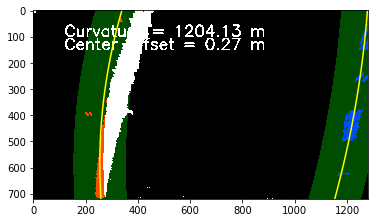

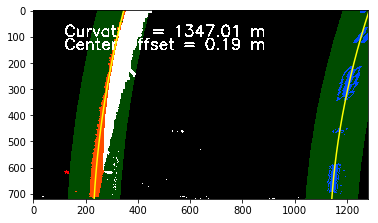

In [12]:
lane_lines,left_fit,right_fit = fit_polynomial(warped_images[0])
#Fit polynomial and show lane lines
for img in warped_images:
    result,left_fitx,right_fitx = search_around_poly(img)
    result = draw_radius_curvature(result,result,left_fitx,right_fitx)    
    plt.imshow(result)
    plt.figure()
    

## Warp the detected lane boundaries back onto the original image.

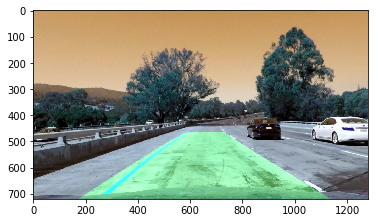

In [13]:

image = cv2.imread('test_images/test1.jpg')
warped = warped_images[0]
undist = cal_undistort(image,objpoints,imgpoints)

margin = 100

# Grab activated pixels
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
### Set the area of search based on activated x-values ###
### within the +/- margin of our polynomial function ###
    
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
        
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
#set source and destination points
src = np.float32([(203,720),(1099,720),(707,463),(580,463)])
dst = np.float32([(203,720),(1099,720),(1099,0),(203,0)])
        
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
        
  

## Some Helper Functions for Pileline

In [25]:
def sliding_window(warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img,left_fit,right_fit,left_fitx,right_fitx,ploty

def sliding_window_from_prior(warped,left_best_fit, right_best_fit):
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_best_fit[0]*(nonzeroy**2) + left_best_fit[1]*nonzeroy + 
                    left_best_fit[2] - margin)) & (nonzerox < (left_best_fit[0]*(nonzeroy**2) + 
                    left_best_fit[1]*nonzeroy + left_best_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_best_fit[0]*(nonzeroy**2) + right_best_fit[1]*nonzeroy + 
                    right_best_fit[2] - margin)) & (nonzerox < (right_best_fit[0]*(nonzeroy**2) + 
                    right_best_fit[1]*nonzeroy + right_best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    ## End visualization steps ##
    
    return result,left_fit,right_fit,left_fitx,right_fitx,ploty

# Checking the lane values
def lane_accuracy(lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty):
    
    #Measuring Radius of Curvature for left and right lanes
    left_curverad = measure_curvature(left_fitx,lane_lines)
    right_curverad = measure_curvature(right_fitx,lane_lines)    
    average_curverad = (left_curverad + right_curverad)/2
    
    # meters per pixel in y dimension
    x_m_per_pix = 3.7/600
    
    mean_distance = np.mean(right_fitx - left_fitx) * x_m_per_pix
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    # Car center, Assuming the camera is mounted in the middle
    car_center = img.shape[1]/2
    # Calculate center offset
    center_offset = abs((lane_center - car_center) * x_m_per_pix)
    
    if mean_distance < 2.5 or mean_distance > 5:
        return False
    if center_offset > 0.5 or center_offset < -0.5 :
        return False
    
    # Checking radius
    
    if average_curverad < 30:
        return False
    if average_curverad > 1000:
        return False
    # Default value
    return True

def get_line_avg(prev_lines, new_line):    
    # Number of frames to average over
    num_frames = 25
    # if there is no new line
    if new_line is None:        
        if len(prev_lines) == 0:
            return previous_lines, None
        else:
            # Return previous line
            return prev_lines, prev_lines[-1]
    else:
        if len(prev_lines) < num_frames:
            # we need at least 10 frames to average over
            prev_lines.append(new_line)
            return prev_lines, new_line
        else:
            # average over the last 10 frames
            prev_lines[0:num_frames-1] = prev_lines[1:]
            prev_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += prev_lines[i]
            new_line /= num_frames
            return prev_lines,new_line
    


## Create a Pipeline to Process Images

In [26]:
left_best_fit = None
right_best_fit = None
prev_best_left_lines = []
prev_best_right_lines = []

def process_image(image):
    original_image = np.copy(image)
    
    #Undistort raw image
    undistort = cal_undistort(original_image,objpoints,imgpoints)
    
    
    #Apply Threshold
    combined_binary = threshold(undistort)
    
    
    #Perform Perspective transform
    warped = perspective(combined_binary)
    
    global left_best_fit
    global right_best_fit
    global prev_best_left_lines
    global prev_best_right_lines
    
    left_fit = None
    right_fit = None
        
    
    #if not left_line.detected or not right_line.detected:
    lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    
    if left_best_fit == None or right_best_fit == None:
        lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    else:
        lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window_from_prior(warped,left_best_fit,right_best_fit)
        
        if left_fit is not None and right_fit is not None:
            if not lane_accuracy(lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty):
                lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    #  Add the values to the best fit array
    
     
    left_best_fit = left_fit
    right_best_fit = right_fit
    
    prev_best_left_lines,left_fitx = get_line_avg(prev_best_left_lines,left_fitx)
    prev_best_right_lines,right_fitx = get_line_avg(prev_best_right_lines,right_fitx)
    
    
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
    #set source and destination points
    src = np.float32([(203,720),(1099,720),(707,463),(580,463)])
    dst = np.float32([(203,720),(1099,720),(1099,0),(203,0)])

     
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
    
    ##Draw Radius and Curvature information
    result = draw_radius_curvature(lane_lines,result,left_fitx,right_fitx)
    
    return result



## Video Output

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:

output = 'test_videos/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos/project_video_output.mp4
[MoviePy] Writing video test_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [13:37<00:00,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/project_video_output.mp4 

CPU times: user 11min 19s, sys: 2.47 s, total: 11min 22s
Wall time: 13min 40s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))